# Notebook for the reproduction of results in [Randomized Linear Gate Set Tomography](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.2.030328).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import my own modules
from src import quantum_utilities as qu
from src import randomized_linear_gst as rlgst

# Import Qiskit basics
from qiskit import QuantumCircuit
from qiskit import Aer, transpile, execute
from qiskit.tools.visualization import plot_histogram

# Import from QiskitAer noise module
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error, amplitude_damping_error, coherent_unitary_error
from qiskit.providers.aer.noise import depolarizing_error

# Import Quantum Information module
import qiskit.quantum_info as qi


## Build noise model

Define initial parameters for you QC system and the error model, as well as the error magnitude.

In [2]:
num_qubits = 1
d2 = 2**(2*num_qubits)
native_gate_list = ['x', 'y', 'z']

error_scale = 1*(10**(-3))


rng = np.random.default_rng(1234)


# create list of native gate operations as numpy array
native_gate_op = [qi.Pauli('X').to_matrix() , qi.Pauli('Y').to_matrix() , qi.Pauli('Z').to_matrix()]
native_gate_channels = [qu.gate_to_channelmatrix(G) for G in native_gate_op]

def noise_model(e_vec):
    NM = np.eye(4)
    NM = np.dot(qu.get_rotation_channel(e_vec[6],'z'),NM)
    NM = np.dot(qu.get_rotation_channel(e_vec[5],'y'),NM)
    NM = np.dot(qu.get_rotation_channel(e_vec[4],'x'),NM)
    NM = np.dot(qu.get_Pauli_channel2(e_vec[1],e_vec[2],e_vec[3]),NM)
    NM = np.dot(qu.get_AD_channel2(e_vec[0]),NM)
    return(NM)

noisy_native_gate_channels = [noise_model(rng.random(7)*error_scale)@gate for gate in native_gate_channels]



def linear_noise_model(e_vec):
    return( np.eye(4) + np.vstack( (np.zeros((1,4)), e_vec.reshape(3,4) )   ) )


# noisy_native_gate_channels = [linear_noise_model(rng.random(12)*error_scale)@gate for gate in native_gate_channels]


In [3]:
print('AGsI:')
print(np.real(qu.AGsI(native_gate_channels, noisy_native_gate_channels)))

AGsI:
0.001297028032845704


Now we will setup initial state and measurement error. Notice that, chosing as POVM $P_0 = |0\rangle \langle 0 | + \frac{a}{\sqrt{2}}(X + Y - Z)$ will only affect the measurement in Z basis as $P_0 = |0\rangle \langle 0 | + \frac{a}{\sqrt{2}}(- Z)$, i.e. with a mis-reading equal to $\frac{a}{\sqrt{2}}$ for both $P(1|0)$ and $P(0|1)$.

In [4]:
# build initial state \rho_in and POVMs
a = 0.01
#a = 0
#a = np.sqrt(np.real(qu.AGsI(native_gate_channels, noisy_native_gate_channels)))

rho_in = np.array([[1, 0],[0, 0]], dtype = np.complex_) + a/np.sqrt(2) * ( qi.Pauli('X').to_matrix() + qi.Pauli('Y').to_matrix() - qi.Pauli('Z').to_matrix())

P0 = rho_in # set measurement POVM
P1 = np.array([[1, 0],[0, 1]], dtype = np.complex_) - P0

rho_dirac = qu.superket(rho_in)
P0_dirac = qu.superbra(P0)

rho_true = qu.superket(np.array([[1,0],[0,0]]))
P0_true = qu.superbra(np.array([[1,0],[0,0]]))

## Sample circuits of intrest

Each circuit will be a list of integers from $1$ to $|\mathcal{G}|$. They will be then arranged into a list of lists, grouping per depth.
NOTE: duplicate circuits have to be discarded.

In [5]:
L_list = [8, 16, 32, 64, 128]
#L_list = [8,16,32]
Nc = 150
#Nc = 24
Nshots = 8192
b_elem = [0,1]

circuit_list = []
circuit_list.append([])
for l in range(len(L_list)):
    circuits = []
    for i in range(Nc):
        c = rng.integers(low=0, high= len(native_gate_list), size=L_list[l]).tolist() 
        while c in circuits:
            c = rng.integers(low=0, high= len(native_gate_list), size=L_list[l]).tolist()
        circuits.append(c)
    circuit_list.append(circuits)

    
Nc_tot = 1 + len(L_list)*Nc
L_list = [0] + L_list


## Compute $\tilde{p}$ and $p$ and build $\mathbf{C}$
Ideal probabilities can be retrived from the same method that builds $\mathbf{C}$. Noisy probabilities have to be simulated apart.

In [6]:
p_noisy = np.zeros((Nc_tot,1))
p_true = np.zeros((Nc_tot,1))
ne_param = len(native_gate_channels)*d2*(d2-1)+2*d2-1
C = np.zeros((Nc_tot, ne_param))

j = 1
p_noisy[0] = qu.my_braket([P0_dirac,rho_dirac]) # null circuit
C[0],p_true[0] = rlgst.get_C_coeff([],native_gate_channels)


for l in range(1,len(L_list)):
    for c in circuit_list[l]:
        C[j],p_true[j] = rlgst.get_C_coeff(c,native_gate_channels)
        gate_list = [noisy_native_gate_channels[gate] for gate in c[::-1] ]
        gate_list.insert(0,P0_dirac)
        gate_list.append(rho_dirac)
        p_noisy[j] = (Nshots - np.sum(np.random.choice(b_elem, Nshots, p =  [qu.my_braket(gate_list)[0,0],1-qu.my_braket(gate_list)[0,0]] )))/Nshots
        j+=1    


## Estimate error $\hat{e}$

In [7]:
# compute C (pseudo)inverse
V, C_eig, WH = np.linalg.svd(C, full_matrices=False)
threshold = Nc_tot*np.finfo(float).eps*C_eig.max()
print(threshold)

inv_diag = [1/lambda_ if np.abs(lambda_) >= threshold else 0 for lambda_ in C_eig]

C_inv = WH.conjugate().T @ np.diag(inv_diag) @ V.conjugate().T # right inverse of C

# estimate e
e = C_inv@(p_noisy-p_true)


8.717014085100965e-11


Analyze $\mathbf{C}$ matrix.

In [8]:
print(C_eig)
print(inv_diag)
print(e.T)

[5.22742229e+02 6.67844986e+01 5.51789915e+01 5.46971467e+01
 5.33614626e+01 2.01801325e+01 1.80751360e+01 6.50999245e-14
 4.52410357e-14 3.82791956e-14 3.82791956e-14 3.82791956e-14
 3.82791956e-14 3.82791956e-14 3.82791956e-14 3.82791956e-14
 3.82791956e-14 3.82791956e-14 3.82791956e-14 3.82791956e-14
 3.82791956e-14 3.82791956e-14 3.82791956e-14 3.82791956e-14
 3.82791956e-14 3.82791956e-14 3.82791956e-14 3.82791956e-14
 3.82791956e-14 3.82791956e-14 3.82791956e-14 3.82791956e-14
 3.82791956e-14 3.82791956e-14 3.82791956e-14 3.82791956e-14
 3.82791956e-14 3.82791956e-14 3.82791956e-14 3.82791956e-14
 3.82791956e-14 3.76649483e-14 2.25084257e-14]
[0.0019129887444338924, 0.014973534592050794, 0.018122839371453633, 0.01828248932109024, 0.018740116021044396, 0.04955368844095921, 0.05532461826481214, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[-2.92933912e-18 -1.15084454e-17  5.84539993e-17 -7.62254418e-19
  -9.80235021e-2

Extract noisy maps from $e$.

In [9]:
#err_list = []
est_noisy_gate_channels = []

for i in range(len(native_gate_channels)):
    e_i = np.eye(4) + np.vstack(( np.zeros((1,4)), e[i*12:(i+1)*12].reshape(3,4)))
    #err_list.append(e_i)
    est_noisy_gate_channels.append(e_i@native_gate_channels[i])
    
rho_est = qu.superket(np.array([[1, 0],[0, 0]], dtype = np.complex_)) +  np.vstack( (np.array([0]), e[len(native_gate_channels)*12:len(native_gate_channels)*12+3]) )
P0_est = qu.superbra(np.array([[1, 0],[0, 0]], dtype = np.complex_)) + e[len(native_gate_channels)*12+3:].conjugate().T

print(rho_dirac)
print(rho_est)
print(P0_dirac)
print(P0_est)

[[0.70710678]
 [0.01      ]
 [0.01      ]
 [0.69710678]]
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.69458076]]
[[0.70710678 0.01       0.01       0.69710678]]
[[0.69613807 0.         0.         0.69458076]]


In [10]:
print(rho_est-rho_dirac)
print(P0_est-P0_dirac)

[[ 0.        ]
 [-0.01      ]
 [-0.01      ]
 [-0.00252602]]
[[-0.01096871 -0.01       -0.01       -0.00252602]]


## Run test-set circuits

In [11]:
L_test_list = [10, 50, 100, 200, 500, 1000]
Nc_test = 1000

Nc_test_tot = len(L_test_list)*Nc_test

N_it = 10

delta = np.zeros((N_it,len(L_test_list)))

for it in range(N_it):
    delta_it = []
    circuit_test_list = []
    for l in range(len(L_test_list)):
        circ = [rng.integers(low=0, high= len(native_gate_list), 
                             size=L_test_list[l]).tolist() for i in range(Nc_test)] 

        p_test_true_l = np.zeros((Nc_test,1))  # true noisy p
        p_test_est_l = np.zeros((Nc_test,1)) # estimated p
        j = 0
       
        for c in circ:
            true_gate_list = [noisy_native_gate_channels[gate] for gate in c[::-1] ]
            true_gate_list.insert(0,P0_dirac)
            true_gate_list.append(rho_dirac)
            #true_gate_list.insert(0,P0_true)
            #true_gate_list.append(rho_true)
            
            est_gate_list = [est_noisy_gate_channels[gate] for gate in c[::-1] ]
            est_gate_list.insert(0,P0_est)
            est_gate_list.append(rho_est)
            #est_gate_list.insert(0,P0_true)
            #est_gate_list.append(rho_true)

            p_test_true_l[j] = qu.my_braket(true_gate_list)[0,0]
            p_test_est_l[j] = qu.my_braket(est_gate_list)[0,0]
            j+=1 
        
        delta_it.append(np.linalg.norm((p_test_true_l - p_test_est_l),ord=1)/Nc_test)
    print(delta_it)
    delta[it] = np.array(delta_it)


delta_mean = np.mean(delta,axis=0)


[0.006105649323063641, 0.008660761887202599, 0.01816661860125861, 0.029319587863588556, 0.06833115942095212, 0.1330888062855204]
[0.00612541777474723, 0.008756532351630422, 0.018530519994508148, 0.029199449985245103, 0.06681649171282035, 0.1319909883147199]
[0.006088016501734593, 0.008710521030011997, 0.01797157888868663, 0.02947047038022766, 0.0684847027314594, 0.13215959732255647]
[0.006099379106217057, 0.00870275261580627, 0.018093900772401285, 0.029503781631770587, 0.06799116021391176, 0.1329058452964759]
[0.006134069045540836, 0.008731670318682983, 0.017968042824752038, 0.031093326775557185, 0.06737706095479562, 0.13264628972839076]
[0.00615300426328322, 0.008736666889997536, 0.017766612845354107, 0.030944599143434424, 0.06805567186107853, 0.13222521323585534]
[0.006155422195825389, 0.008763206565919574, 0.017810269902611923, 0.02979327409703671, 0.06832596055855306, 0.13142467995621593]
[0.006146388343613113, 0.008714613124776852, 0.018403379143538394, 0.029830758390221358, 0.069

/home/alb/Scrivania/Quantum/Projects/sparseGST/sparsegst_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


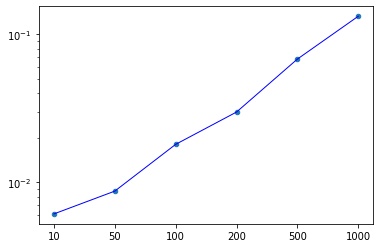

In [12]:
plt.figure()
ax = plt.axes()
x_space = [0,1,2,3,4,5]
plt.plot(x_space, delta_mean, 'b', lw=1)
plt.scatter(x_space, delta_mean, s=20)
plt.yscale("log")
ax.set_xticklabels([0]+L_test_list)
plt.show()